# Homework 4

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *Dimensional Fund Advisors*

*Names:* Dylan Masters, Eduardo Scheffer,  Gabrielle Pan, Niall Mandal

***

# Section 1: DFA's Strategy

> **Note:** This section is not graded, but you should review these concepts and be prepared to discuss them.

### 1. Investment Philosophy

1. **DFA’s Belief:** In 100 words or less, describe DFA’s belief about how to find premium in the market.
2. **Strategy Dependency:** To what degree does their strategy rely on:
   - Individual equity analysis?
   - Macroeconomic fundamentals?
   - Efficient markets?
3. **Active or Passive:** Are DFA’s funds active or passive?
4. **Stock Types:** Define "value" and "growth" stocks according to DFA.

*Answer:*

1. DFA believed that investment premiums came from various sources of risk. Rather than depending solely on market risk (beta), DFA’s philosophy built on academic research by Rolf Banz and later Fama and French (1992, 1993). They proposed a three-factor model that added two portfolios to the market portfolio: “high-minus-low” (HML) for book-to-market equity and “small-minus-big” (SMB) for market capitalization. The HML portfolio, or Value factor, posits that cheaper stocks may be distressed and thus carry a risk premium. The SMB portfolio, or Size factor, reflects the higher risk associated with smaller companies, which justifies a premium for holding smaller-cap stocks.

2. Strategy dependence on:
    - Individual equity analysis: LOW to NONE
    - Macroeconomic fundamentals: LOW to NONE
    - Efficient markets: HIGH

3. DFA's funds are passive.

4. Value stocks are stocks that have relatively high (book value of equity) / (market value of equity) compared to the other stocks. Growth stocks are stocks that relatively low (book value of equity) / (market value of equity) compared to the other stocks.

### 2. Challenges for DFA’s View

1. **1980s Challenge:** What challenge did DFA's model face in the 1980s?
2. **1990s Challenge:** What challenge did DFA's model face in the 1990s?

*Answer:*

- Small capitalization stocks were passing through a period of poor performance compared to large capitalization stocks because of a deep recession that the US entered in early 1980. As the decade went through, the economy recover but small caps continue to lag. Since Small Caps was one of the largest DFA strategies, the asset manager suffered.

- Value stocks were considerably lagging behind grwoth stocks, specially high-tech growth mega caps, which was the exact type of stocks DFA avoided, so again, the Value strategy from DFA was also performing badly.

### 3. The Market

1. **Market Composition:** Based on Exhibit 3, how many firms are "large cap," and what percentage of market value do they represent?
2. **Value Factor:** Why might an investor still be interested in the U.S. value factor, even though it underperformed in the long term except for 1963-1981?


*Answer:*
- Large Caps: 207 companies, representing 70% of the overall market
- Value might still be interesting because of the diversification and because in the long run, it still overperforms growth.

***

# Section 2: The Factors

> **Data Source:** Use the data in `dfa_analysis_data.xlsx`, specifically the **MKT** column for excess market returns.

### 1. Factor Performance Statistics

Calculate and report the following statistics for each of the three subsamples:
   - Mean
   - Volatility
   - Sharpe Ratio
   - VaR (0.05)

#### Subsamples
- Beginning - 1980
- 1981 - 2001
- 2002 - End

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from typing import Union, List, Callable

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

import statsmodels.api as sm

import os
import sys

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
# parent_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # Get parent path (if using .py file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)
sys.path.insert(0, parent_path) # Add parent path to system path (for importing modules)

import utils.portfolio_management_functions as pm

In [2]:
# Helper Functions:

def read_excel_default(excel_name: str, sheet_name: str = None, index_col : int = 0, parse_dates: bool =True, print_sheets: bool = False, **kwargs):
    """
    Reads an Excel file and returns a DataFrame with specified options.

    Parameters:
    excel_name (str): The path to the Excel file.
    index_col (int, default=0): Column to use as the row index labels of the DataFrame.
    parse_dates (bool, default=True): Boolean to parse dates.
    print_sheets (bool, default=False): If True, prints the names and first few rows of all sheets.
    sheet_name (str or int, default=None): Name or index of the sheet to read. If None, reads the first sheet.
    **kwargs: Additional arguments passed to `pd.read_excel`.

    Returns:
    pd.DataFrame: DataFrame containing the data from the specified Excel sheet.

    Notes:
    - If `print_sheets` is True, the function will print the names and first few rows of all sheets and return None.
    - The function ensures that the index name is set to 'date' if the index column name is 'date' or 'dates', or if the index contains date-like values.
    """
    if print_sheets:
        excel_file = pd.ExcelFile(excel_name)  # Load the Excel file to get sheet names
        sheet_names = excel_file.sheet_names
        n = 0
        while True:
            try:
                sheet = pd.read_excel(excel_name, sheet_name=n)
                print(f'Sheet name: {sheet_names[n]}')
                print("Columns: " + ", ".join(list(sheet.columns)))
                print(sheet.head(3))
                n += 1
                print('-' * 70)
                print('\n')
            except:
                return
    sheet_name = 0 if sheet_name is None else sheet_name
    data = pd.read_excel(excel_name, index_col=index_col, parse_dates=parse_dates,  sheet_name=sheet_name, **kwargs)
    if data.index.name is not None:
        if data.index.name.lower() in ['date', 'dates']:
            data.index.name = 'date'
    elif isinstance(data.index[0], (datetime.date, datetime.datetime)):
        data.index.name = 'date'
    return data


def returns_to_df(returns: Union[pd.DataFrame, pd.Series, List[pd.Series]], name: str = "Returns"):
    """
    Converts returns to a DataFrame if it is a Series or a list of Series.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.

    Returns:
    pd.DataFrame: DataFrame of returns.
    """
    if isinstance(returns, pd.DataFrame):
        returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    elif isinstance(returns, list):
        returns_list = returns.copy()
        returns = pd.DataFrame({})

        for series in returns_list:
            if isinstance(series, pd.Series):
                returns = returns.merge(series, right_index=True, left_index=True, how='outer')
            else:
                raise TypeError(f'{name} must be either a pd.DataFrame or a list of pd.Series')
            
    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print(f'Could not convert {name} to float. Check if there are any non-numeric values')
        pass

    return returns


def fix_dates_index(returns: pd.DataFrame):
    """
    Fixes the date index of a DataFrame if it is not in datetime format and convert returns to float.

    Parameters:
    returns (pd.DataFrame): DataFrame of returns.

    Returns:
    pd.DataFrame: DataFrame with datetime index.
    """
    # Check if 'date' is in the columns and set it as the index

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    # Convert dates to datetime
    try:
        returns.index = pd.to_datetime(returns.index.map(lambda x: x.date()))
    except ValueError:
        print('Could not convert the index to datetime. Check the index format for invalid dates.')
    
    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print('Could not convert returns to float. Check if there are any non-numeric values')
        pass

    return returns


def filter_columns_and_indexes(
    df: pd.DataFrame,
    keep_columns: Union[list, str],
    drop_columns: Union[list, str],
    keep_indexes: Union[list, str],
    drop_indexes: Union[list, str]
):
    """
    Filters a DataFrame based on specified columns and indexes.

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    keep_columns (list or str): Columns to keep in the DataFrame.
    drop_columns (list or str): Columns to drop from the DataFrame.
    keep_indexes (list or str): Indexes to keep in the DataFrame.
    drop_indexes (list or str): Indexes to drop from the DataFrame.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """

    if not isinstance(df, (pd.DataFrame, pd.Series)):
        return df
    
    df = df.copy()

    # Columns
    if keep_columns is not None:
        keep_columns = [re.escape(col) for col in keep_columns]
        keep_columns = "(?i).*(" + "|".join(keep_columns) + ").*" if isinstance(keep_columns, list) else "(?i).*" + keep_columns + ".*"
        df = df.filter(regex=keep_columns)
        if drop_columns is not None:
            print('Both "keep_columns" and "drop_columns" were specified. "drop_columns" will be ignored.')

    elif drop_columns is not None:
        drop_columns = [re.escape(col) for col in drop_columns]
        drop_columns = "(?i).*(" + "|".join(drop_columns) + ").*" if isinstance(drop_columns, list) else "(?i).*" + drop_columns + ".*"
        df = df.drop(columns=df.filter(regex=drop_columns).columns)

    # Indexes
    if keep_indexes is not None:
        keep_indexes = [re.escape(col) for col in keep_indexes]
        keep_indexes = "(?i).*(" + "|".join(keep_indexes) + ").*" if isinstance(keep_indexes, list) else "(?i).*" + keep_indexes + ".*"
        df = df.filter(regex=keep_indexes, axis=0)
        if drop_indexes is not None:
            print('Both "keep_indexes" and "drop_indexes" were specified. "drop_indexes" will be ignored.')

    elif drop_indexes is not None:
        drop_indexes = [re.escape(col) for col in drop_indexes]
        drop_indexes = "(?i).*(" + "|".join(drop_indexes) + ").*" if isinstance(drop_indexes, list) else "(?i).*" + drop_indexes + ".*"
        df = df.filter(regex=keep_indexes, axis=0)
    
    return df


def calc_cummulative_returns(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    return_plot: bool = True,
    fig_size: Union[int, float] = 7,
    return_series: bool = False,
    name: str = None,
    timeframes: Union[None, dict] = None,
):
    """
    Calculates cumulative returns from a time series of returns.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    return_plot (bool, default=True): If True, plots the cumulative returns.
    fig_size (int or float, default = 7): Size of the plot for cumulative returns. Scale: 1.5
    return_series (bool, default=False): If True, returns the cumulative returns as a DataFrame.
    name (str, default=None): Name for the title of the plot or the cumulative return series.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate cumulative returns for each period.

    Returns:
    pd.DataFrame or None: Returns cumulative returns DataFrame if `return_series` is True.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if timeframes is not None:
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            calc_cummulative_returns(
                timeframe_returns,
                return_plot=True,
                fig_size=fig_size,
                return_series=False,
                name=name,
                timeframes=None
            )
        return
   
    returns = (1 + returns).cumprod()
    returns = returns - 1
    title = f'Cummulative Returns {name}' if name else 'Cummulative Returns'
    if return_plot:
        returns.plot(
            title=title,
            figsize=(fig_size*1.5, fig_size),
            grid=True,
            xlabel='Date',
            ylabel='Cummulative Returns'
        )
    if return_series == True or return_plot == False:
        return returns
    

def calc_returns_statistics(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    annual_factor: int = None,
    provided_excess_returns: bool = None,
    rf: Union[pd.Series, pd.DataFrame] = None,
    var_quantile: Union[float , List] = .05,
    timeframes: Union[None, dict] = None,
    return_tangency_weights: bool = False,
    correlations: Union[bool, List] = False,
    tail_risks: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    _timeframe_name: str = None,
):
    """
    Calculates summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    provided_excess_returns (bool, default=None): Whether excess returns are already provided.
    rf (pd.Series or pd.DataFrame, default=None): Risk-free rate data.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    timeframes (dict or None, default=None): Dictionary of timeframes [start, finish] to calculate statistics for each period.
    return_tangency_weights (bool, default=True): If True, returns tangency portfolio weights.
    correlations (bool or list, default=True): If True, returns correlations, or specify columns for correlations.
    tail_risks (bool, default=True): If True, include tail risk statistics.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Summary statistics of the returns.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if rf is not None:
        rf = returns_to_df(rf) # Convert returns to DataFrame if it is a Series
        fix_dates_index(rf) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float
        if len(rf.index) != len(returns.index):
            raise Exception('"rf" index must be the same lenght as "returns"')
        if type(rf) == pd.DataFrame:
            rf = rf.iloc[:, 0].to_list()
        elif type(rf) == pd.Series:
            rf = rf.to_list()

    # Assume annualization factor of 12 for monthly returns if None and notify user
    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12

    
    if keep_columns is None:
        keep_columns = ['Accumulated Return', 'Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Min', 'Mean', 'Max']
        if tail_risks == True:
            keep_columns += ['Skewness', 'Excess Kurtosis', f'Historical VaR ({var_quantile})', f'Annualized Historical VaR ({var_quantile})', 
                             f'Historical CVaR ({var_quantile})', f'Annualized Historical CVaR ({var_quantile})', 'Max Drawdown', 
                             'Peak Date', 'Bottom Date', 'Recovery', 'Duration (days)']

    # Iterate to calculate statistics for multiple timeframes
    if isinstance(timeframes, dict):
        all_timeframes_summary_statistics = pd.DataFrame({})
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_returns = timeframe_returns.rename(columns=lambda col: col + f' ({name})')
            timeframe_summary_statistics = calc_returns_statistics(
                returns=timeframe_returns,
                annual_factor=annual_factor,
                provided_excess_returns=provided_excess_returns,
                rf=rf,
                var_quantile=var_quantile,
                timeframes=None,
                correlations=correlations,
                _timeframe_name=name,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            all_timeframes_summary_statistics = pd.concat(
                [all_timeframes_summary_statistics, timeframe_summary_statistics],
                axis=0
            )
        return all_timeframes_summary_statistics

    # Calculate summary statistics for a single timeframe
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)

    if provided_excess_returns is True:
        if rf is not None:
            print('Excess returns and risk-free were both provided.'
                ' Excess returns will be consider as is, and risk-free rate given will be ignored.\n')
        summary_statistics['Sharpe'] = returns.mean() / returns.std()
    else:
        try:
            if rf is None:
                print('No risk-free rate provided. Interpret "Sharpe" as "Mean/Volatility".\n')
                summary_statistics['Sharpe'] = returns.mean() / returns.std()
            else:
                excess_returns = returns.apply(lambda x: x - rf)

                summary_statistics['Sharpe'] = excess_returns.mean() / returns.std()
        except Exception as e:
            print(f'Could not calculate Sharpe: {e}')

    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    
    if tail_risks == True:
        tail_risk_stats = stats_tail_risk(returns,
                                        annual_factor=annual_factor,
                                        var_quantile=var_quantile,
                                        keep_indexes=keep_indexes,
                                        drop_indexes=drop_indexes)
        
        summary_statistics = summary_statistics.join(tail_risk_stats)
        
    if return_tangency_weights is True:
        tangency_weights = calc_tangency_port(returns)
        summary_statistics = summary_statistics.join(tangency_weights)

    if correlations is True or isinstance(correlations, list):
        returns_corr = returns.corr()
        if _timeframe_name:
            returns_corr = returns_corr.rename(columns=lambda col: col.replace(f' {_timeframe_name}', ''))
        returns_corr = returns_corr.rename(columns=lambda col: col + ' Correlation')
        if isinstance(correlations, list):
            correlation_names = [col + ' Correlation' for col  in correlations]
            # Check if all selected columns exist in returns_corr
            not_in_returns_corr = [col for col in correlation_names if col not in returns_corr.columns]
            if len(not_in_returns_corr) > 0:
                not_in_returns_corr = ", ".join([c.replace(' Correlation', '') for c in not_in_returns_corr])
                raise Exception(f'{not_in_returns_corr} not in returns columns')
            returns_corr = returns_corr[[col + ' Correlation' for col  in correlations]]
        summary_statistics = summary_statistics.join(returns_corr)
    
    return filter_columns_and_indexes(
        summary_statistics,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )


def stats_tail_risk(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    annual_factor: int = None,
    var_quantile: Union[float , List] = .05,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
):
    """
    Calculates tail risk summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: tail risk summary statistics of the returns.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    tail_risk_stats = pd.DataFrame(index=returns.columns)

    tail_risk_stats['Skewness'] = returns.skew()
    tail_risk_stats['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        tail_risk_stats[f'Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0)
        tail_risk_stats[f'Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        if annual_factor:
            tail_risk_stats[f'Annualized Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
            tail_risk_stats[f'Annualized Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    cum_returns = (1 + returns).cumprod()
    maximum = cum_returns.cummax()
    drawdown = cum_returns / maximum - 1

    tail_risk_stats['Accumulated Return'] = cum_returns.iloc[-1] - 1
    tail_risk_stats['Max Drawdown'] = drawdown.min()
    tail_risk_stats['Peak Date'] = [maximum[col][:drawdown[col].idxmin()].idxmax() for col in maximum.columns]
    tail_risk_stats['Bottom Date'] = drawdown.idxmin()
    
    recovery_date = []
    for col in cum_returns.columns:
        prev_max = maximum[col][:drawdown[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([cum_returns[col][drawdown[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    tail_risk_stats['Recovery'] = recovery_date

    tail_risk_stats["Duration (days)"] = [
        (i - j).days if i != pd.NaT else "-" for i, j in
        zip(tail_risk_stats["Recovery"], tail_risk_stats["Bottom Date"])
    ]

    return filter_columns_and_indexes(
        tail_risk_stats,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

def calc_correlations(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    print_highest_lowest: bool = True,
    matrix_size: Union[int, float] = 7,
    show_heatmap: bool = True,
    return_matrix: bool = False,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Calculates the correlation matrix of the provided returns and optionally prints or visualizes it.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    print_highest_lowest (bool, default=True): If True, prints the highest and lowest correlations.
    matrix_size (int or float, default=7): Size of the heatmap for correlation matrix visualization.
    show_heatmap (bool, default=False): If True, returns a heatmap of the correlation matrix.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    sns.heatmap or pd.DataFrame: Heatmap of the correlation matrix or the correlation matrix itself.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    returns = filter_columns_and_indexes(
        returns,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

    correlation_matrix = returns.corr()

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.4f}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.4f}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')

    if show_heatmap == True:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )
        plt.show()

    if return_matrix:
        return correlation_matrix
    else:
        return None
    



def calc_tangency_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    cov_matrix_factor: str = 1,
    target_return: Union[None, float] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'Tangency'
):
    """
    Calculates tangency portfolio weights based on the covariance matrix of returns.
        When `target_return` is provided, the weights are rescaled to achieve the target return:
            - If returns are the "excess returns", then the rescaled tangency portfolio is also in the ~MV frontier.

    Parameters:
    returns (pd.DataFrame or List of pd.Series): Time series of returns.
    cov_matrix_factor (str, default=1): Weight for the covariance matrix. If 1, uses the sample covariance matrix, otherwise uses a shrinkage estimator.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the tangency weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='Tangency'): Name for labeling the weights and portfolio.

    Returns:
    pd.DataFrame or pd.Series: Tangency portfolio weights or portfolio returns if `return_port_ret` is True.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    # Calculate the covariance matrix
    if cov_matrix_factor == 1:
        cov_matrix = returns.cov()
    else:
        cov_matrix = returns.cov()
        cov_matrix_diag = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_matrix_factor * cov_matrix + (1-cov_matrix_factor) * cov_matrix_diag
    
    cov_matrix_inv = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(returns.columns))
    mu = returns.mean() # Use mean monthly excess returns as a proxy for expected excess returns: (mu)

    # Calculate the tangency portfolio weights
    scaling = 1 / (ones.T @ cov_matrix_inv @ mu)
    tangency_wts = scaling * (cov_matrix_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangency_wts, columns=[f'{name} Portfolio'])
    
    # Calculate the portfolio returns
    port_returns = returns @ tangency_wts

    # Rescale weights to target return
    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        tangency_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler
        
        tangency_wts = tangency_wts.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)

    
    # Plot the tangency weights
    if show_graphic == True:
        ax = tangency_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    if cov_matrix_factor != 1:
        tangency_wts = tangency_wts.rename({f'{name} Portfolio': f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
        port_returns = port_returns.rename({f'{name} Portfolio':f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
        tangency_wts = tangency_wts.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                            f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                            f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
        
        
    if return_port_returns:
        return port_returns
    return tangency_wts

def calc_equal_weights_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    target_return: Union[float, None] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'Equal Weights'
):
    """
    Calculates equal weights for the portfolio based on the provided returns.

    Parameters:
    returns (pd.DataFrame or List or pd.Series): Time series of returns.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the equal weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='Equal Weights'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: Equal portfolio weights or portfolio returns if `return_port_returns` is True.
    """

    returns = returns_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    equal_wts = pd.DataFrame(
        index=returns.columns,
        data=[1 / len(returns.columns)] * len(returns.columns),
        columns=[f'{name} Portfolio']
    )
    port_returns = returns @ equal_wts

    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name}'].mean() * annual_factor)
        equal_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler
        
        equal_wts = equal_wts.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)

    # Plot the equal weights
    if show_graphic:
        ax = equal_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    if return_port_returns:
        return port_returns
    return equal_wts


def calc_regression(
    Y: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    X: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    intercept: bool = True,
    annual_factor: Union[None, int] = None,
    return_model: bool = False,
    return_fitted_values: bool = False,
    p_values: bool = True,
    tracking_error: bool = True,
    r_squared: bool = True,
    treynor_info_ratio: bool = False,
    market_name: str = 'SPY US Equity',
    sortino_ratio: bool = False,
    timeframes: Union[None, dict] = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
    ):
    
    """
    Performs an OLS regression of a "many-to-many" returns time series with optional intercept, timeframes, statistical ratios, and performance ratios.

    Parameters:
    y (pd.DataFrame, pd.Series or List or pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame, pd.Series or List or pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    tracking_error (bool, default=True): If True, calculates the tracking error of the regression.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    treynor_info_ratios (bool, default=True): If True, calculates Treynor and Information ratios.
    market_name (str, default='SPY US Equity'): Name of the market index for the Treynor ratio.
    sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.
    timeframes (dict or None, default=None): Dictionary of timeframes to run separate regressions for each period.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.
    calc_sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.

    Returns:
    pd.DataFrame or model: Regression summary statistics or the model if `return_model` is True.
    """

    X = returns_to_df(X) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(X) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    Y = returns_to_df(Y) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(Y) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if annual_factor is None:
        print("Regression assumes 'annual_factor' equals to 12 since it was not provided")
        annual_factor = 12
    
    y_names = list(Y.columns) if isinstance(Y, pd.DataFrame) else [Y.name]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add the intercept
    if intercept:
        X = sm.add_constant(X)
 
    # Check if y and X have the same length
    if len(X.index) != len(Y.index):
        print(f'y has lenght {len(Y.index)} and X has lenght {len(X.index)}. Joining y and X by y.index...')
        df = Y.join(X, how='left')
        df = df.dropna()
        Y = df[y_names]
        X = df.drop(columns=y_names)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match and there are less observations than degrees of freedom. Cannot calculate regression')


    if isinstance(timeframes, dict):
        all_timeframes_regressions = pd.DataFrame()
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_Y = Y.loc[timeframe[0]:timeframe[1]]
                timeframe_X = X.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_Y = Y.loc[timeframe[0]:]
                timeframe_X = X.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_Y = Y.loc[:timeframe[1]]
                timeframe_X = X.loc[:timeframe[1]]
            else:
                timeframe_Y = Y.copy()
                timeframe_X = X.copy()
            if len(timeframe_Y.index) == 0 or len(timeframe_X.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_Y = timeframe_Y.rename(columns=lambda col: col + f' ({name})')
            timeframe_regression = calc_regression(
                Y=timeframe_Y,
                X=timeframe_X,
                intercept=intercept,
                annual_factor=annual_factor,
                warnings=False,
                return_model=False,
                return_fitted_values=False,
                p_values=p_values,
                tracking_error=tracking_error,
                treynor_info_ratio=treynor_info_ratio,
                timeframes=None,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            timeframe_regression.index = [f"{timeframe_regression.index} ({name})"]
            all_timeframes_regressions = pd.concat(
                [all_timeframes_regressions, timeframe_regression],
                axis=0
            )
        return all_timeframes_regressions
    
    regression_statistics = pd.DataFrame(index=y_names, columns=[])	
    fitted_values_all = pd.DataFrame(index=Y.index, columns=y_names)

    for y_asset in y_names:
        # Fit the regression model: 
        y = Y[y_asset]
        try:
            ols_model = sm.OLS(y, X, missing="drop")
        except ValueError:
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(y, X, missing="drop")
            print(f'"{y_asset}" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame')
        
        ols_results = ols_model.fit()

        if return_model:
            return(ols_results)

        elif return_fitted_values:
            fitted_values = ols_results.fittedvalues
            fitted_values = fitted_values.rename(f'{y_asset}^')
            fitted_values_all[y_asset] = fitted_values

        else:
            # Calculate/get statistics:

            if r_squared == True:
                regression_statistics.loc[y_asset, 'R-Squared'] = ols_results.rsquared # R-squared
                if intercept == False:
                    print('No intercept in regression. R-Squared might not make statistical sense.')

            regression_statistics.loc[y_asset, 'Observed Mean'] = y.mean()
            regression_statistics.loc[y_asset, 'Observed Std Dev'] = y.std()

            # Residual Standard Error (RSE) and Mean Absolute Error (MAE)
            residuals =  ols_results.resid
            regression_statistics.loc[y_asset, 'MAE'] = abs(residuals).mean()
            rse = (sum(residuals**2) / (len(residuals) - len(ols_results.params))) ** 0.5 
            regression_statistics.loc[y_asset, 'RSE'] = rse

            if intercept == True:
                regression_statistics.loc[y_asset, 'Alpha'] = ols_results.params.iloc[0]
                regression_statistics.loc[y_asset, 'Annualized Alpha'] = ols_results.params.iloc[0] * annual_factor # Annualized Alpha 
                
                if p_values == True: 
                    regression_statistics.loc[y_asset, 'P-Value (Alpha)'] = ols_results.pvalues.iloc[0] # Alpha p-value

            # Process betas and p-values for explanatory variables
            X_names = list(X.columns[1:]) if intercept else list(X.columns)
            betas = ols_results.params[1:] if intercept else ols_results.params
            betas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues
            
            for i in range(len(X_names)):
                regression_statistics.loc[y_asset, f"Beta ({X_names[i]})"] = betas.iloc[i] # Betas
                if p_values == True: 
                    regression_statistics.loc[y_asset, f"P-Value ({X_names[i]})"] = betas_p_values.iloc[i] # Beta p-values

            if tracking_error == True:
                regression_statistics.loc[y_asset, 'Tracking Error'] = residuals.std() 
                regression_statistics.loc[y_asset, 'Annualized Tracking Error'] = regression_statistics.loc[y_asset, 'Tracking Error'] * (annual_factor ** 0.5) # Annualized Residuals Volatility

            if treynor_info_ratio == True:
                try:
                    treynor_ratio = y.mean() / regression_statistics.loc[y_asset, f'Beta ({market_name})']
                    regression_statistics.loc[y_asset, 'Treynor Ratio'] = treynor_ratio # Treynor Ratio
                    regression_statistics.loc[y_asset, 'Annualized Treynor Ratio'] = treynor_ratio * annual_factor # Annualized Treynor Ratio
                except:
                    print(f'{market_name} is not a factor in the regression. Treynor Ratio cannot be calculated.')
                if intercept:
                    regression_statistics.loc[y_asset, 'Information Ratio'] = regression_statistics.loc[y_asset, 'Alpha'] / residuals.std() # Information Ratio
                    regression_statistics.loc[y_asset, 'Annualized Information Ratio'] = regression_statistics.loc[y_asset, 'Information Ratio'] * (annual_factor ** 0.5) # Annualized Information Ratio
            
            if sortino_ratio:
                try:
                    regression_statistics.loc[y_asset, 'Sortino Ratio'] = regression_statistics.loc[y_asset, 'Fitted Mean'] / Y[Y < 0].std()
                except Exception as e:
                    print(f'Cannot calculate Sortino Ratio: {str(e)}. Set "calc_sortino_ratio" to False or review function')
    
    if return_fitted_values:
        return fitted_values_all
    
    else:
        if regression_statistics.shape[0] == 1:
            regression_statistics = regression_statistics.T
        return filter_columns_and_indexes(
            regression_statistics,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )


def calc_cross_section_regression(
    Y: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    X: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    intercept: bool = True,
    return_model: bool = False,
    return_fitted_values: bool = False,
    p_values: bool = True,
    r_squared: bool = True,
    regression_name: str = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Performs an OLS regression for cross-sectional data with optional intercept and statistical ratios.

    Parameters:
    Y (pd.DataFrame, pd.Series or List of pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame, pd.Series or List of pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame or model: Regression summary statistics or the model if `return_model` is True.
    """

    X = returns_to_df(X)  # Convert inputs to DataFrame if not already
    Y = returns_to_df(Y)

    y_names = list(Y.columns) if isinstance(Y, pd.DataFrame) else [Y.name]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add intercept if specified
    if intercept:
        X = sm.add_constant(X)

    # Check alignment of Y and X
    if len(X.index) != len(Y.index):
        print(f'y has length {len(Y.index)} and X has length {len(X.index)}. Joining y and X by y.index...')
        df = Y.join(X, how='left').dropna()
        Y = df[y_names]
        X = df.drop(columns=y_names)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match, and there are fewer observations than degrees of freedom.')

    regression_statistics = pd.DataFrame(index=y_names, columns=[])
    fitted_values_all = pd.DataFrame(index=Y.index, columns=y_names)

    for y_asset in y_names:
        # Fit the regression model
        y = Y[y_asset]
        try:
            ols_model = sm.OLS(y, X, missing="drop")
        except ValueError:
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(y, X, missing="drop")
            print(f'"{y_asset}" Required to reset indexes to make regression work. Pass "y" and "X" as pd.DataFrame')

        ols_results = ols_model.fit()

        if return_model:
            return ols_results

        elif return_fitted_values:
            fitted_values = ols_results.fittedvalues.rename(f'{y_asset}^')
            fitted_values_all[y_asset] = fitted_values

        else:
            # Calculate/get statistics

            if r_squared:
                regression_statistics.loc[y_asset, 'R-Squared'] = ols_results.rsquared
                if not intercept:
                    print('No intercept in regression. R-Squared might not be interpretable.')
            
            # Mean and Standard Deviation of y
            regression_statistics.loc[y_asset, 'Observed Mean'] = y.mean()
            regression_statistics.loc[y_asset, 'Observed Std Dev'] = y.std()

            # Residual Standard Error (RSE) and Mean Absolute Error (MAE)
            residuals = ols_results.resid
            regression_statistics.loc[y_asset, 'MAE'] = abs(residuals).mean()
            rse = (sum(residuals**2) / (len(residuals) - len(ols_results.params))) ** 0.5 
            regression_statistics.loc[y_asset, 'RSE'] = rse

        
            if intercept:
                regression_statistics.loc[y_asset, 'Alpha'] = ols_results.params.iloc[0]
                if p_values:
                    regression_statistics.loc[y_asset, 'P-Value (Alpha)'] = ols_results.pvalues.iloc[0]

            # Process betas and p-values for explanatory variables
            X_names = list(X.columns[1:]) if intercept else list(X.columns)
            betas = ols_results.params[1:] if intercept else ols_results.params
            betas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues

            for i, x_name in enumerate(X_names):
                regression_statistics.loc[y_asset, f"Beta ({x_name})"] = betas.iloc[i]
                if p_values:
                    regression_statistics.loc[y_asset, f"P-Value ({x_name})"] = betas_p_values.iloc[i]

    if return_fitted_values:
        return fitted_values_all
    
    else:
        regression_statistics_t = regression_statistics.T
        if regression_statistics_t.columns[0] == 0:
            if regression_name is None:
                regression_name = 'Cross-Sectional'
            regression_statistics_t.rename(columns={0: regression_name}, inplace=True)
        return filter_columns_and_indexes(
            regression_statistics_t,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )


In [3]:
# Check data in the file (sheets, columns, data):
INFILE = "data/dfa_analysis_data.xlsx"
try:
    read_excel_default(INFILE, print_sheets = True)
except FileNotFoundError as e:
    print(f'{e}.\nCheck file in {parent_path}')
    

Sheet name: descriptions
Columns: Unnamed: 0, Name, Unit, Construction, Description
  Unnamed: 0    Name           Unit         Construction                                        Description
0     Mkt-RF  Market  Excess Return  Market-cap-weighted                                        US Equities
1        SMB    Size  Excess Return      Small Minus Big             Long small stocks and short big stocks
2        HML   Value  Excess Return       High Minus Low  Long value (high book-to-market) stocks and sh...
----------------------------------------------------------------------


Sheet name: factors
Columns: Date, Mkt-RF, SMB, HML, RF
        Date  Mkt-RF     SMB     HML     RF
0 1926-07-31  0.0296 -0.0256 -0.0243 0.0022
1 1926-08-31  0.0264 -0.0117  0.0382 0.0025
2 1926-09-30  0.0036 -0.0140  0.0013 0.0023
----------------------------------------------------------------------


Sheet name: portfolios (total returns)
Columns: Date, SMALL LoBM, ME1 BM2, ME1 BM3, ME1 BM4, SMALL HiBM, M

In [4]:
# Import data from the file:
description = pd.read_excel(INFILE, sheet_name='descriptions',index_col=0)
factors_returns = pd.read_excel(INFILE, sheet_name='factors',index_col=0)
portfolios_total_returns = pd.read_excel(INFILE, sheet_name='portfolios (total returns)',index_col=0)

display(description)

,Name,Unit,Construction,Description
Mkt-RF,Market,Excess Return,Market-cap-weighted,US Equities
SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
RF,Risk-free rate,Total Return,Tbills,NaN


In [5]:
SUBSAMPLES = [(factors_returns.index[0].strftime('%Y-%m-%d'), '1980-12-31'),
              ('1981-01-01', '2001-12-31'),
              ('2002-01-01', factors_returns.index[-1].strftime('%Y-%m-%d'))]

for i, (start_date, end_date) in enumerate(SUBSAMPLES):
    print(f'\n\n\nSubsample {i+1}: {start_date} - {end_date}\n')
    factors_subsample = factors_returns.loc[start_date:end_date]
    
    # Calculate the factor returns statistics:
    factor_stats = calc_returns_statistics(factors_subsample,
                                       provided_excess_returns=True,
                                       annual_factor=12,
                                       var_quantile = 0.05,
                                       keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe',
                                                     'Annualized Historical VaR (5.0%)'])
    display(factor_stats)
# Calculate the portfolio returns statistics:
#calc_returns_statistics




Subsample 1: 1926-07-31 - 1980-12-31



,Annualized Mean,Annualized Vol,Annualized Sharpe,Annualized Historical VaR (5.0%)
Mkt-RF,0.0811,0.2051,0.3957,-0.2909
SMB,0.0340,0.1146,0.2966,-0.1503
HML,0.0495,0.1338,0.3697,-0.1486
RF,0.0277,0.0077,3.6148,0.0000





Subsample 2: 1981-01-01 - 2001-12-31



,Annualized Mean,Annualized Vol,Annualized Sharpe,Annualized Historical VaR (5.0%)
Mkt-RF,0.0773,0.1574,0.4908,-0.2236
SMB,-0.0009,0.1183,-0.0073,-0.1611
HML,0.0638,0.1112,0.5736,-0.1448
RF,0.0631,0.0078,8.1353,0.0085





Subsample 3: 2002-01-01 - 2024-08-31



,Annualized Mean,Annualized Vol,Annualized Sharpe,Annualized Historical VaR (5.0%)
Mkt-RF,0.0895,0.1546,0.5787,-0.2727
SMB,0.0110,0.0889,0.1238,-0.1353
HML,0.0005,0.1073,0.0050,-0.1429
RF,0.0146,0.0050,2.9082,0.0000


### 2. Factor Premium Analysis

1. **Premium Evaluation:** Does each factor have a premium in each subsample?
2. **Size Factor Premium:** Does the size factor's premium decrease after 1980?
3. **Value Factor Premium:** Does the value factor’s premium decrease during the 1990s?
4. **Post-2002 Performance:** How have the factors performed since 2002?


<span style="color:red">*Answer*</span>

1. No, in 1981-2000, SMB factor had negative average excess returns. In  2001-2024, HML also had a zero average excess returns.
2. Yes, small caps had a poorer performance after 1980 compared to large caps.
3. Looking at the 1981-2000, we cannot say that, because the average excess returns increased when compared to before 1980. However, the reading says that value stocks did perform poorer than growth, specially high-tech stocks.
4. Since 2001, the market factor performed well (8.95% average excess returns), while Size and Value factor performed badly (0% and 1.1% excess returns, respectively).

### 3. Factor Correlation Analysis

1. **Correlation Matrix:** Report the correlation matrix for the three factors. Comment on whether the construction method succeeded in keeping correlations low.


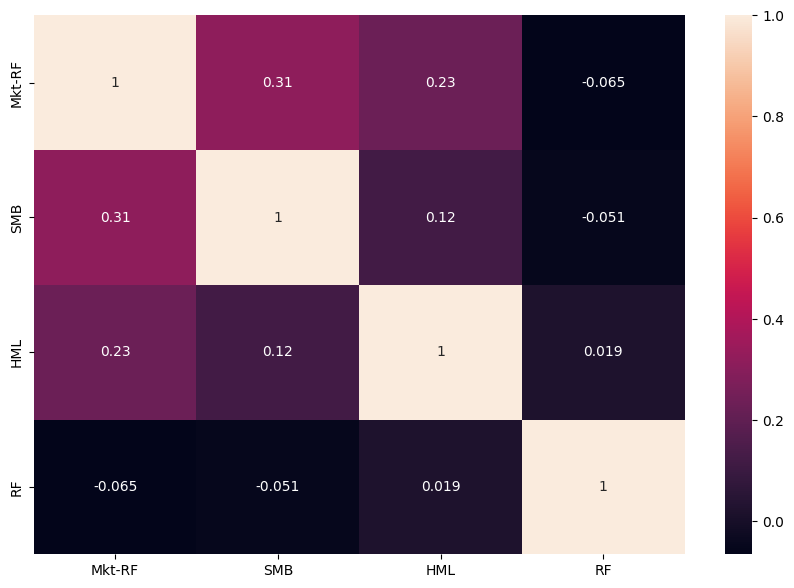

In [6]:
calc_correlations(factors_returns, print_highest_lowest=False)

<span style="color:red">*Answer*</span>
- The factor model construction succeeded in keeping correlations low.

### 4. Cumulative Returns Plot

1. **1981-2001 Plot:** Plot the cumulative returns of the three factors.
2. **2002-Present Plot:** Plot the cumulative returns of the three factors.
3. **Factor Value Analysis:** Were all three factors valuable during 1981-2001 and post-2001? Would you recommend DFA emphasize all three?


Comparison between Mkt-RF and Equal Weight (Mkt-RF, SMB, HML) in 1981 - 2001:



,Annualized Mean,Annualized Vol,Annualized Sharpe
Mkt-RF,0.0773,0.1574,0.4908
Equal Weights Portfolio,0.0467,0.0546,0.8551



Comparison between Mkt-RF and Equal Weight (Mkt-RF, SMB, HML) in 2002 - 2024:



,Annualized Mean,Annualized Vol,Annualized Sharpe
Mkt-RF,0.0895,0.1546,0.5787
Equal Weights Portfolio,0.0337,0.0806,0.4179


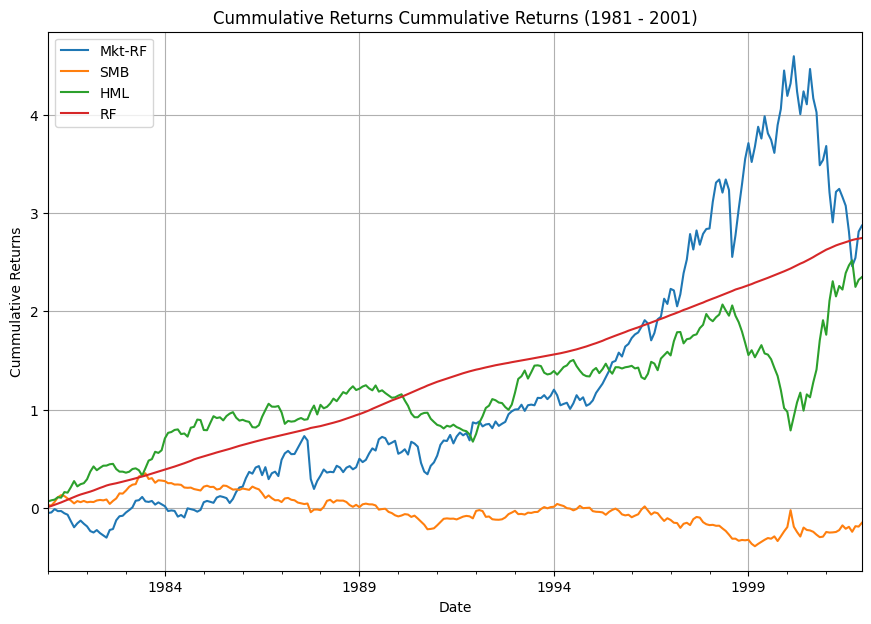

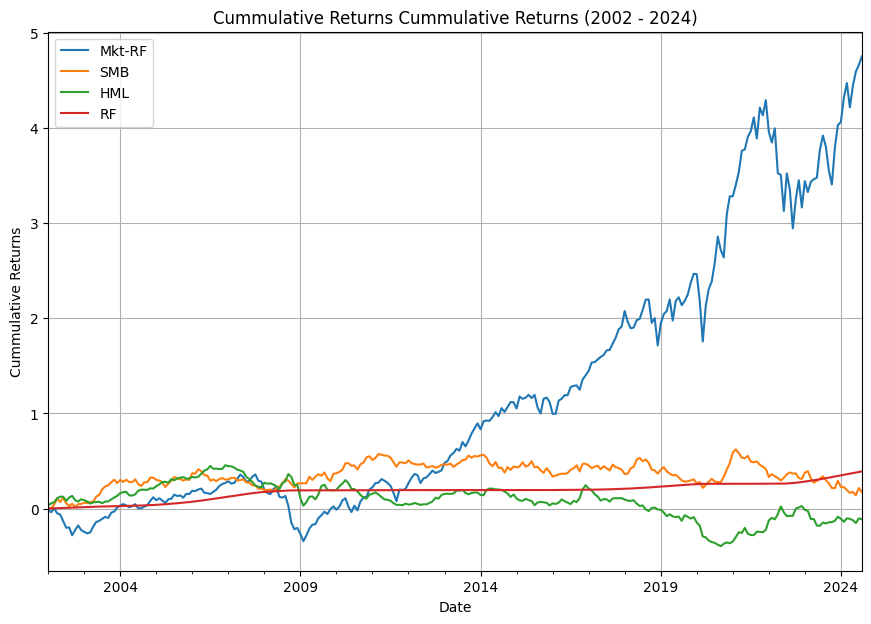

In [7]:
for i, (start_date, end_date) in enumerate(SUBSAMPLES[1:]):
    factors_subsample = factors_returns.loc[start_date:end_date]
    calc_cummulative_returns(factors_subsample, name = f'Cummulative Returns ({start_date[:4]} - {end_date[:4]})')
    equal_weights_returns = calc_equal_weights_port(factors_subsample[['Mkt-RF', 'SMB', 'HML']], annual_factor=12, return_port_returns=True)
    returns_stats = calc_returns_statistics(returns=[factors_subsample['Mkt-RF'], equal_weights_returns.iloc[:,0]],
                               annual_factor = 12,
                               provided_excess_returns=True,
                               tail_risks=True,
                               keep_columns = ['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe'])
    
    print(f"Comparison between Mkt-RF and Equal Weight (Mkt-RF, SMB, HML) in {start_date[:4]} - {end_date[:4]}:\n")
    display(returns_stats)
    print()
    

<span style="color:red">*Answer*</span>
- Based only on the cummulative plots, it appears that the size factor was not valuable during 1981-2002, and both the value and size factors were not valuable during 2002-2024, so we would recommend DFA to emphasize more the market factor.
- However, when looking at the sharpe ratio of only the Market factor vs an equal-weight portfolio of all 3 factors, the sharpe ratio is actually better for the equal weight portfolio during 1981-2002.

***

# Section 3: CAPM

> **Data:** Use the **PORTFOLIOS** data (monthly total return data) and **Risk-Free rate** from the factors tab for conversions.

### 1. Portfolio Summary Statistics

1. Convert total returns to excess returns using the Risk-Free rate.
2. Calculate the following annualized statistics:
   - Mean
   - Volatility
   - Sharpe Ratio
   - VaR (0.05)

#### Question:
- Can differences in mean excess returns be explained by differences in volatilities or VaR (0.05) statistics?


In [8]:
rf = factors_returns['RF'].copy()
portfolios_returns = pd.merge(portfolios_total_returns, rf, how='inner', left_index=True, right_index=True)
portfolios_returns = portfolios_returns.apply(lambda x: x - portfolios_returns['RF']).drop(columns=['RF'])

portfolios_returns_stats = calc_returns_statistics(returns=portfolios_returns,
                                   annual_factor=12,
                                   provided_excess_returns=False,
                                   rf=rf, 
                                   var_quantile = 0.05,
                                   keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe','Annualized Historical VaR (5.0%)'])

display(portfolios_returns_stats)

print('\n Regression of Annualized Mean on Annualized Vol and Hstorical VaR (5.0%)')
port_annualized_mean_returns = portfolios_returns_stats['Annualized Mean'].copy()
vol_var_regressors = portfolios_returns_stats[['Annualized Vol', 'Annualized Historical VaR (5.0%)']]
calc_cross_section_regression(Y=port_annualized_mean_returns, X=vol_var_regressors, intercept=True)



,Annualized Mean,Annualized Vol,Annualized Sharpe,Annualized Historical VaR (5.0%)
SMALL LoBM,0.0673,0.4149,0.0843,-0.4966
ME1 BM2,0.0808,0.3355,0.1447,-0.4371
ME1 BM3,0.1206,0.3179,0.2779,-0.3622
ME1 BM4,0.1370,0.2860,0.3661,-0.3539
SMALL HiBM,0.1610,0.3195,0.4030,-0.3952
ME2 BM1,0.0762,0.2759,0.1592,-0.3887
ME2 BM2,0.1123,0.2588,0.3093,-0.3389
ME2 BM3,0.1158,0.2497,0.3345,-0.3240
ME2 BM4,0.1243,0.2552,0.3606,-0.3277
ME2 BM5,0.1492,0.3003,0.3895,-0.3912



 Regression of Annualized Mean on Annualized Vol and Hstorical VaR (5.0%)


,Annualized Mean
R-Squared,0.1567
Observed Mean,0.1067
Observed Std Dev,0.0244
MAE,0.0171
RSE,0.0234
Alpha,0.1205
P-Value (Alpha),0.0014
Beta (Annualized Vol),0.6147
P-Value (Annualized Vol),0.0662
Beta (Annualized Historical VaR (5.0%)),0.5133


<span style="color:red">*Answer*</span>

- Differences in Annualized Vol and Annualized Historical VaR (5.0%) are not sufficient to explain variation in the annualized mean return of the portfolios
    - The RSE is almost equal to the standard deviation of the portfolio mean returns, and about 1/4 of the mean of those mean returns. 
    - The R-Squared is low (15.67%)

### 2. CAPM Regression

1. **Time-Series Regression:** Run the CAPM regression for each portfolio and report the betas and alphas.
2. **MAE Calculation:** Calculate the mean-absolute-error (MAE) of the CA
   - **Question:** What would we expect of MAE if CAPM were true?

3. **CAPM Performance Metrics:**
   - Report estimated beta, Treynor Ratio, alpha, and Information Ratio for each regression.

4. **CAPM Hypothesis Check:**
   - What would be true for the Treynor Ratios, alphas, and Information Ratios if CAPM were correct?


In [9]:
# Time-Series CAPM Regression Metrics: R^2, MAE, RSE, Alpha, Beta, p-values
capm_regression_summary = calc_regression(Y=portfolios_returns,
                   X=factors_returns['Mkt-RF'],
                   intercept=True,
                   annual_factor=12,
                   tracking_error=False)
display(capm_regression_summary)

,R-Squared,Observed Mean,Observed Std Dev,MAE,RSE,Alpha,Annualized Alpha,P-Value (Alpha),Beta (Mkt-RF),P-Value (Mkt-RF)
SMALL LoBM,0.5116,0.0056,0.1198,0.0484,0.0837,-0.0054,-0.0648,0.0282,1.6064,0.0000
ME1 BM2,0.5872,0.0067,0.0969,0.0379,0.0623,-0.0028,-0.0336,0.1255,1.3921,0.0000
ME1 BM3,0.6546,0.0101,0.0918,0.0348,0.0540,0.0005,0.0061,0.7489,1.3925,0.0000
ME1 BM4,0.6604,0.0114,0.0826,0.0301,0.0481,0.0028,0.0335,0.0485,1.2583,0.0000
SMALL HiBM,0.6175,0.0134,0.0922,0.0346,0.0571,0.0041,0.0493,0.0145,1.3592,0.0000
ME2 BM1,0.7215,0.0063,0.0796,0.0297,0.0420,-0.0023,-0.0282,0.0577,1.2687,0.0000
ME2 BM2,0.7657,0.0094,0.0747,0.0238,0.0362,0.0010,0.0115,0.3673,1.2259,0.0000
ME2 BM3,0.7829,0.0097,0.0721,0.0220,0.0336,0.0015,0.0174,0.1416,1.1963,0.0000
ME2 BM4,0.7602,0.0104,0.0737,0.0238,0.0361,0.0021,0.0252,0.0476,1.2048,0.0000
ME2 BM5,0.7140,0.0124,0.0867,0.0314,0.0464,0.0030,0.0363,0.0268,1.3738,0.0000


<span style="color:red">*Answer*</span>

2. If CAPM were true, than the MAE would be very close to zero, since the model would be able to explain the returns of the portfolios near perfectly.

In [10]:
capm_regression_performance = calc_regression(Y=portfolios_returns,
                   X=factors_returns['Mkt-RF'],
                   intercept=True,
                   annual_factor=12,
                   treynor_info_ratio=True,
                   market_name='Mkt-RF',
                   keep_columns = ['Annualized Alpha', 'Beta', 'Annualized Treynor Ratio', 'Annualized Information Ratio'])
display(capm_regression_performance)

print(f"The risk premium for the market is: {factors_returns['Mkt-RF'].mean()*12:.4f}%")

,Annualized Alpha,Beta (Mkt-RF),Annualized Treynor Ratio,Annualized Information Ratio
SMALL LoBM,-0.0648,1.6064,0.0419,-0.2237
ME1 BM2,-0.0336,1.3921,0.0581,-0.1561
ME1 BM3,0.0061,1.3925,0.0866,0.0326
ME1 BM4,0.0335,1.2583,0.1089,0.2010
SMALL HiBM,0.0493,1.3592,0.1185,0.2493
ME2 BM1,-0.0282,1.2687,0.0600,-0.1934
ME2 BM2,0.0115,1.2259,0.0916,0.0918
ME2 BM3,0.0174,1.1963,0.0968,0.1497
ME2 BM4,0.0252,1.2048,0.1032,0.2019
ME2 BM5,0.0363,1.3738,0.1086,0.2258


The risk premium for the market is: 0.0822%


<span style="color:red">*Answer*</span>

4. If CAPM were correct then the alphas (and, consequently), the Information Ratios should be zero. The Traynor Ratios should be all equal to the market risk premium.

### 3. Cross-Sectional Estimation

1. Run the regression \( E[r̃i] = η + β_{i,m} \lambda_m + υ \).
2. **Regression Statistics:**
   - R-squared
   - Intercept (η)
   - Regression Coefficient (λm)
3. **Question:** What values would these statistics have if CAPM held true?


In [11]:
portfolio_betas = capm_regression_summary['Beta (Mkt-RF)'] # Beta of the portfolios (25 data points)
port_annualized_mean_returns = portfolios_returns.mean() * 12 # Mean excess returns of the portfolios (25 data points)
calc_cross_section_regression(Y=port_annualized_mean_returns,
                                 X=portfolio_betas,
                                 intercept=True,
                                 regression_name='Annualized Mean Returns ~ Beta (Mkt-RF)')

,Annualized Mean Returns ~ Beta (Mkt-RF)
R-Squared,0.0916
Observed Mean,0.1067
Observed Std Dev,0.0244
MAE,0.0179
RSE,0.0237
Alpha,0.0503
P-Value (Alpha),0.1903
Beta (Beta (Mkt-RF)),0.0463
P-Value (Beta (Mkt-RF)),0.1414


<span style="color:red">*Answer*</span>

- If CAPM held true:
    - R-squared would be 1, but it is 0.916
    - Intercept would be zero, which indeed is.
    - Regression coefficient would be equal to the market risk premium.

### 4. DFA’s Belief in Size and Value Premium

- Does the evidence support DFA's belief that size and value portfolios hold premiums independent of CAPM?


<span style="color:red">*Answer*</span>

- Yes, because if the markets are efficient, the expected excess return (risk premium) of an asset or portfolio must be explained by a risk factor.
- Since the market beta is not enough to explain the returns of the portfolios, there must be factors that are not captured by the market beta, and so, independent of CA

***

# Section 4: Extensions

### 1. MV Model with Tangency Portfolio

1. Re-run the analysis of CAPM regression (Section 3) using the in-sample tangency portfolio of the 25 portfolios.
   - **Findings:** Summarize your observations.

In [12]:
tangent_portfolio_returns = calc_tangency_port(portfolios_returns, annual_factor=12, return_port_returns=True)
capm_regression_summary = calc_regression(Y=tangent_portfolio_returns,
                   X=factors_returns['Mkt-RF'],
                   intercept=True,
                   annual_factor=12,
                   tracking_error=False)
display(capm_regression_summary)

,Tangency Portfolio
R-Squared,0.1925
Observed Mean,0.0230
Observed Std Dev,0.0763
MAE,0.0492
RSE,0.0686
Alpha,0.0187
Annualized Alpha,0.2241
P-Value (Alpha),0.0000
Beta (Mkt-RF),0.6282
P-Value (Mkt-RF),0.0000


<span style="color:red">*Answer*</span>

- The tangency portfolio has an even lower R-squared (0.1925) when compared to the individual portfolios. If CAPM were true, the R-squared would be 1, since the market portfolio is the tangency portfolio under CA
- The tangency portfolio also has a higher mean and lower std dev than the individual portfolios (and consequently higher sharpe ratio), which makes sense.
- The alpha is not statistically significant, as opposed to each individual portfolio's alpha.

### 2. Fama-French 3-Factor Model

1. Re-run the analysis using the Fama-French 3-Factor Model.
   - **Findings:** Summarize your observations.

In [13]:
# Time-Series CAPM Regression Metrics: R^2, MAE, RSE, Alpha, Beta, p-values
capm_regression_summary = calc_regression(Y=portfolios_returns,
                   X=factors_returns[['Mkt-RF', 'SMB', 'HML']],
                   intercept=True,
                   annual_factor=12,
                   p_values=True,
                   tracking_error=False)
display(capm_regression_summary)

,R-Squared,Observed Mean,Observed Std Dev,MAE,RSE,Alpha,Annualized Alpha,P-Value (Alpha),Beta (Mkt-RF),P-Value (Mkt-RF),Beta (SMB),P-Value (SMB),Beta (HML),P-Value (HML)
SMALL LoBM,0.6619,0.0056,0.1198,0.0368,0.0697,-0.0070,-0.0835,0.0007,1.2784,0.0000,1.4640,0.0000,0.3528,0.0000
ME1 BM2,0.8238,0.0067,0.0969,0.0250,0.0407,-0.0040,-0.0484,0.0008,1.0740,0.0000,1.5325,0.0000,0.2022,0.0000
ME1 BM3,0.8729,0.0101,0.0918,0.0192,0.0328,-0.0014,-0.0166,0.1507,1.0770,0.0000,1.2467,0.0000,0.5390,0.0000
ME1 BM4,0.9300,0.0114,0.0826,0.0141,0.0219,0.0008,0.0099,0.2017,0.9417,0.0000,1.2232,0.0000,0.5747,0.0000
SMALL HiBM,0.9284,0.0134,0.0922,0.0153,0.0247,0.0013,0.0159,0.0681,0.9787,0.0000,1.3048,0.0000,0.8949,0.0000
ME2 BM1,0.9109,0.0063,0.0796,0.0167,0.0238,-0.0024,-0.0285,0.0007,1.0890,0.0000,1.1353,0.0000,-0.2184,0.0000
ME2 BM2,0.9330,0.0094,0.0747,0.0132,0.0194,0.0002,0.0022,0.7479,1.0206,0.0000,0.9959,0.0000,0.1224,0.0000
ME2 BM3,0.9357,0.0097,0.0721,0.0121,0.0183,0.0002,0.0028,0.6696,0.9894,0.0000,0.8261,0.0000,0.3431,0.0000
ME2 BM4,0.9526,0.0104,0.0737,0.0110,0.0161,0.0003,0.0042,0.4596,0.9658,0.0000,0.8158,0.0000,0.5669,0.0000
ME2 BM5,0.9527,0.0124,0.0867,0.0128,0.0189,0.0005,0.0056,0.3982,1.0677,0.0000,0.9210,0.0000,0.8789,0.0000


<span style="color:red">*Answer*</span>

- From the time-series regression results above, we can see that, when compared to the regression using only the market factor, in the Fama-French 3-Factor Model:
    - Mean Absolute Error and Residual Square Error decreased
    - R-squared increased
    - More Alphas are now nor significantly different from zero (although some still are).

In [14]:
capm_regression_performance = calc_regression(Y=portfolios_returns,
                   X=factors_returns[['Mkt-RF', 'SMB', 'HML']],
                   intercept=True,
                   annual_factor=12,
                   treynor_info_ratio=True,
                   market_name='Mkt-RF',
                   keep_columns = ['Annualized Alpha', 'Beta', 'Annualized Treynor Ratio', 'Annualized Information Ratio'])
display(capm_regression_performance)

,Annualized Alpha,Beta (Mkt-RF),Beta (SMB),Beta (HML),Annualized Treynor Ratio,Annualized Information Ratio
SMALL LoBM,-0.0835,1.2784,1.4640,0.3528,0.0526,-0.3462
ME1 BM2,-0.0484,1.0740,1.5325,0.2022,0.0753,-0.3433
ME1 BM3,-0.0166,1.0770,1.2467,0.5390,0.1120,-0.1469
ME1 BM4,0.0099,0.9417,1.2232,0.5747,0.1455,0.1305
SMALL HiBM,0.0159,0.9787,1.3048,0.8949,0.1645,0.1865
ME2 BM1,-0.0285,1.0890,1.1353,-0.2184,0.0700,-0.3458
ME2 BM2,0.0022,1.0206,0.9959,0.1224,0.1100,0.0328
ME2 BM3,0.0028,0.9894,0.8261,0.3431,0.1170,0.0436
ME2 BM4,0.0042,0.9658,0.8158,0.5669,0.1287,0.0756
ME2 BM5,0.0056,1.0677,0.9210,0.8789,0.1398,0.0863


<span style="color:red">*Answer*</span>

- The alphas and Information ratio are now closer to zero, which is what we would expect if the Fama-French 3-Factor Model were a better model for explaining the returns of the portfolios in efficient markets.
- The Market Beta is still the most important factor, but smaller, since part of the risk is now explained by the value and size betas.

### 3. CAPM Hypothesis Test

1. **H-Statistic:** 
$$
H = T \left[ 1 + (\text{SR}_m)^2 \right]^{-1} \alpha' \Sigma_{\epsilon}^{-1} \alpha \sim \chi^2_n
$$

   - **Question:** Which test is stricter, H-statistic significance or individual alpha t-tests?
   - **Conceptual Question:** How does H relate to testing if \( r̃m \) spans the tangency portfolio?


<span style="color:red">*Answer*</span>

- The H-statistic significance is stricter than the individual's alpha t-tests:
    - By performing multiple t-tests simultaneously increases the likelyhood of finding at least one significant result purely by chance (there is still a 5% chance in a 95% confidence interval), which might lead to false positives of non-zero alphas.
    - The H-test, on the other hand, combines all the t-tests into a single test accounting for the alphas joint distribution, reducing the probability of deceting a deviation from the CAPM model purely by chance.
- As mentioned previously, if the CAPM holds, then the market portfolio is the tangency portfolio. So, if the CAPM holds, there should be only once source of risk, with no additional alpha to contribute to the portfolio's return. The H-statistic tests if the market portfolio is the tangency portfolio, by testing if the alphas are zero.